In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import yaml
import glob
import tqdm

import pickle
import argparse
from typing import Optional
from functools import partial
import pandas as pd
import rasterio
# from flux_load_data_vInf3 import flux_dataset, flux_dataloader
# from flux_regress import RegressionModel_flux

from PIL import Image
# from flux_load_data_vInf3 import load_raster
# from flux_load_data_vInf3 import preprocess_image
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from torcheval.metrics import R2Score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint, RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger
from torchgeo.trainers import BaseTask

from terratorch.models import EncoderDecoderFactory
from terratorch.datasets import HLSBands
from terratorch.tasks import PixelwiseRegressionTask
from terratorch.models.pixel_wise_model import freeze_module
from huggingface_hub import hf_hub_download
from terratorch.models.backbones.prithvi_mae import PrithviViT

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as v2

from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_recall_fscore_support

In [2]:
class prithvi_terratorch(nn.Module):
  def __init__(self, prithvi_weight, model_instance, input_size):
    super(prithvi_terratorch, self).__init__()
    # load checkpoint for Prithvi_global
    self.weights_path = prithvi_weight
    self.checkpoint = torch.load(self.weights_path)
    self.input_size = input_size
    self.prithvi_model = model_instance   
    self.prithvi_model.load_state_dict(self.checkpoint, strict=False)

  def freeze_encoder(self):
    freeze_module(self.prithvi_model)

  def forward(self,x,temp,loc,mask):
    latent,_,ids_restore = self.prithvi_model.forward(x,temp,loc,mask)
    return latent

In [3]:
def load_raster(path, if_img=1, crop=None):
  with rasterio.open(path) as src:
    img = src.read(out_dtype=np.float32)
    # load  selected 4 bands for Sentinnel 2 (S2)
    if if_img==1:
      bands=[0,1,2,3]
      img = img[bands,:,:]
    # img = np.where(img == NO_DATA, NO_DATA_FLOAT, img)# update our NO_DATA with -0.9999 -- chips are already scaled
    # print("img size",img.shape) 
    if crop:
      img = img[:, -crop[0]:, -crop[1]:]
  # print('return from load ras')
  return img

def preprocess_image(image, means, stds):        
    # normalize image
    means1 = means.reshape(-1,1,1)  # Mean across height and width, for each channel
    stds1 = stds.reshape(-1,1,1)    # Std deviation across height and width, for each channel
    normalized = ((image - means1) / stds1)
    normalized = torch.from_numpy(normalized).to(torch.float32)
    #normalized = torch.from_numpy(normalized.reshape(1, normalized.shape[0], 1, *normalized.shape[-2:])).to(torch.float32)
    #print('return from norm')
    return normalized

In [8]:
class TrainDataset(Dataset):
  def __init__(self, dir_sentinel, dir_landsat, metadata, subset, num_classes, transform_sentinel=None, transform_landsat=None,
              mean_sentinel=np.array([0.0]), std_sentinel=np.array([1.0])):
    self.subset = subset
    self.transform_sentinel = transform_sentinel
    self.mean_sentinel = np.array(mean_sentinel)
    self.std_sentinel = np.array(std_sentinel)
    self.transform_landsat = transform_landsat
    self.dir_sentinel = dir_sentinel
    self.dir_landsat = dir_landsat
    self.num_classes = num_classes
    self.metadata = metadata
    self.metadata = self.metadata.dropna(subset="speciesId").reset_index(drop=True)
    self.metadata['speciesId'] = self.metadata['speciesId'].astype(int)
    self.label_dict = self.metadata.groupby('surveyId')['speciesId'].apply(list).to_dict()
    self.metadata = self.metadata.drop_duplicates(subset="surveyId").reset_index(drop=True)

  def __len__(self):
    return len(self.metadata)

  def __getitem__(self, idx):
    survey_id = self.metadata.surveyId[idx]
    species_ids = self.label_dict.get(survey_id, [])  # Get list of species IDs for the survey ID
    label = torch.zeros(self.num_classes).scatter(0, torch.tensor(species_ids), torch.ones(len(species_ids)))

    sample_landsat = torch.nan_to_num(torch.load(os.path.join(self.dir_landsat, f"GLC25-PA-{self.subset}-landsat-time-series_{survey_id}_cube.pt"), weights_only=True))
    if self.transform_landsat:
      sample_landsat = self.transform_landsat(sample_landsat)
      
    dir1, dir2 = survey_id % 100, (survey_id // 100) % 100
    dir2_str = f"{dir2}" if survey_id < 10000 else f"{dir2:02}"
    path_sentinel = os.path.join(self.dir_sentinel, f"{dir1:02}", dir2_str, f"{survey_id}.tiff")
    image_sentinel = preprocess_image(load_raster(path_sentinel) / 1e4, self.mean_sentinel, self.std_sentinel)
    sample_sentinel = torch.nan_to_num(image_sentinel)
    if self.transform_sentinel:
      sample_sentinel = self.transform_sentinel(sample_sentinel)
    #TODO add transformations RandomRotation by 90 (write own?)
    return sample_sentinel, sample_landsat, label, survey_id
    
class TestDataset(TrainDataset):
  def __init__(self, dir_sentinel, dir_landsat, metadata, subset, num_classes=None, transform_sentinel=None, transform_landsat=None,
              mean_sentinel=np.array([0.0]), std_sentinel=np.array([1.0])):
    self.subset = subset
    self.transform_sentinel = np.array(transform_sentinel)
    self.mean_sentinel = np.array(mean_sentinel)
    self.std_sentinel = np.array(std_sentinel)
    self.transform_landsat = transform_landsat
    self.dir_sentinel = dir_sentinel
    self.dir_landsat = dir_landsat
    self.metadata = metadata
    self.num_classes = num_classes
      
  def __getitem__(self, idx):
    survey_id = self.metadata.surveyId[idx]
    sample_landsat = torch.nan_to_num(torch.load(os.path.join(self.dir_landsat, f"GLC25-PA-{self.subset}-landsat_time_series_{survey_id}_cube.pt"), weights_only=True))
    if self.transform_landsat:
      sample_landsat = self.transform_landsat(sample_landsat)
      
    dir1, dir2 = survey_id % 100, (survey_id // 100) % 100
    dir2_str = f"{dir2}" if survey_id < 10000 else f"{dir2:02}"
    path_sentinel = os.path.join(self.dir_sentinel, f"{dir1:02}", dir2_str, f"{survey_id}.tiff")
    image_sentinel = preprocess_image(load_raster(path_sentinel) / 1e4, self.mean_sentinel, self.std_sentinel)
    sample_sentinel = torch.nan_to_num(image_sentinel)
    if self.transform_landsat:
      sample_landsat = self.transform_landsat(sample_landsat)
    return sample_sentinel, sample_landsat, survey_id

torch.Size([4, 64, 64])


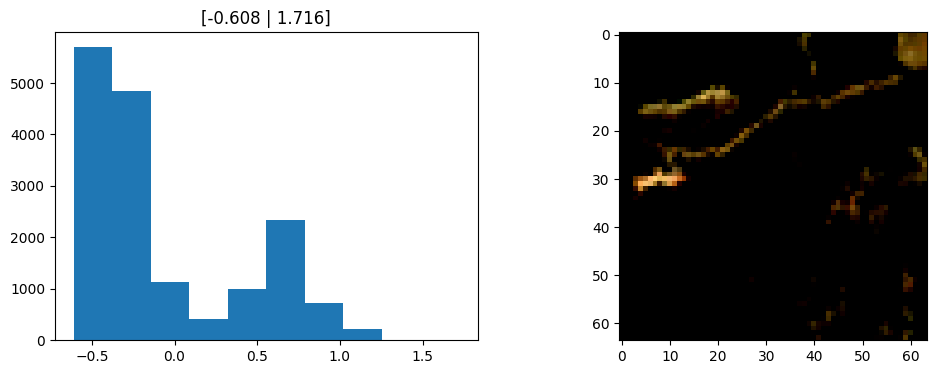

torch.Size([4, 64, 64])


In [27]:
batch_size = 128
num_classes = 11255
mean_sentinel = [0.1]
std_sentinel = [0.13]
transform_landsat = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    # v2.RandomRotation(180)
])

transform_sentinel = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    # v2.RandomRotation(180)
])


# Load Training metadata
path_data = "/home/gt/DATA/geolifeclef-2025"
train_path_sentinel = os.path.join(path_data, "SatelitePatches/PA-train")
train_path_landsat = os.path.join(path_data, "SateliteTimeSeries-Landsat/cubes/PA-train")
train_metadata_path = os.path.join(path_data, "GLC25_PA_metadata_train.csv")
train_metadata = pd.read_csv(train_metadata_path)
train_dataset = TrainDataset(train_path_sentinel, train_path_landsat, train_metadata, subset="train", num_classes=num_classes, transform_sentinel=transform_sentinel,
                            mean_sentinel=mean_sentinel, std_sentinel=std_sentinel)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
print(train_dataset[0][0].shape)
plt.figure(figsize=[12,4])
plt.subplot(1, 2, 1)
plt.hist(train_dataset[0][0].flatten())
plt.title("[%.3f | %.3f]" % (np.min(train_dataset[0][0].numpy()), np.max(train_dataset[0][0].numpy())))
plt.subplot(1, 2, 2)
plt.imshow(torch.permute(train_dataset[0][0][:3], [1,2,0]))
plt.show()


# Load Test metadata
test_path_sentinel = os.path.join(path_data, "SatelitePatches/PA-test")
test_path_landsat = os.path.join(path_data, "SateliteTimeSeries-Landsat/cubes/PA-test")
test_metadata_path = os.path.join(path_data, "GLC25_PA_metadata_test.csv")
test_metadata = pd.read_csv(test_metadata_path)
test_dataset = TestDataset(test_path_sentinel, test_path_landsat, test_metadata, subset="test", transform_sentinel=None,
                          mean_sentinel=mean_sentinel, std_sentinel=std_sentinel)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print(test_dataset[0][0].shape)

In [28]:
patch_size = [1,16,16]
n_frame = 1
n_channel = 4
embed_dim = 1024
decoder_depth = 8
num_heads = 16
mlp_ratio = 4
head_dropout = 0.0
      
# ### Creating an instance of our custom model used to estimate the carbon flux problem. 
path_prithvi = "/home/gt/gdrive/codes_misc/prithvi/carbon_flux"
wt_file = os.path.join(path_prithvi, "Prithvi_EO_V2_300M_TL.pt")
if not os.path.isfile(wt_file):
  hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-EO-2.0-300M-TL", filename="Prithvi_EO_V2_300M_TL.pt", local_dir=path_prithvi)

prithvi_instance = PrithviViT(
        patch_size=patch_size,
        num_frames=n_frame,
        in_chans=n_channel,
        embed_dim=embed_dim,
        decoder_depth=decoder_depth,
        num_heads=num_heads,
        mlp_ratio=mlp_ratio,
        head_dropout=head_dropout,
        backbone_input_size=[1,64,64],
        encoder_only=False,
        padding=True,
)
prithvi_model = prithvi_terratorch(wt_file, prithvi_instance, [1,64,64])
prithvi_model.freeze_encoder()

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("DEVICE = CUDA")
prithvi_model.to(device);

DEVICE = CUDA


In [29]:
def set_seed(seed):
    torch.manual_seed(seed) # Set seed for Python's built-in random number generator
    np.random.seed(seed) # Set seed for numpy
    if torch.cuda.is_available(): # Set seed for CUDA if available
        torch.cuda.manual_seed_all(seed)
        # Set cuDNN's random number generator seed for deterministic behavior
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(69)

In [30]:
class SimpleDecoder(nn.Module):
    def __init__(self, input_dim=[17,1024], hidden_dim=256, output_dim=128):
        super(SimpleDecoder, self).__init__()
        self.fc1 = nn.Linear(input_dim[1], hidden_dim) # 1024 to 256; shape 17x1024 to 10x256
        self.hidden_dim_flattened=input_dim[0] * hidden_dim #17 is feature dim+ class token in MAE; 17x256 to 4352
        self.fc2 = nn.Linear(self.hidden_dim_flattened, output_dim) # 4352 to 128
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x)) #shape 17x1024 to 17x256 ORG
        x = torch.reshape(x,(x.shape[0], x.shape[1]*x.shape[2])) #17x256 to 4352 
        x = self.fc2(x) # 4352 to 128 Output shape 
        return x

class ModifiedPrithvi(nn.Module):
    def __init__(self, num_classes, prithvi_model):
        super(ModifiedPrithvi, self).__init__()
        self.prithvi_model = prithvi_model
        self.decoder = SimpleDecoder(input_dim=[17,1024], hidden_dim=256, output_dim=128)
        self.fc_final = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.prithvi_model(x, None, None, torch.tensor(0, device=device))
        x = self.decoder(x)
        x = self.fc_final(x)
        return x

In [31]:
# Check if cuda is available
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("DEVICE = CUDA")
num_classes = 11255 # Number of all unique classes within the PO and PA data.
model = ModifiedPrithvi(num_classes, prithvi_model).to(device)

DEVICE = CUDA


In [32]:
img_array = [train_dataset[i][0] for i in range(10)]
img_batch = torch.stack(img_array)[:,:,None,:,:] / 1000
prithvi_res = prithvi_model.forward(img_batch.to(device), None, None, torch.tensor(0, device=device))
print(prithvi_res.to(device).shape)
model_res = model.forward(img_batch.to(device))
print(model_res.shape)

torch.Size([10, 17, 1024])
torch.Size([10, 11255])


In [33]:
from torchsummary import summary
#summary(model, (4, 1, 64, 64))

In [34]:
# Hyperparameters
learning_rate = 0.0002
num_epochs = 40
positive_weigh_factor = 1.0

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=25, verbose=True)

In [36]:
print(f"Training for {num_epochs} epochs started.")

for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data_sentinel, data_landsat, targets, _) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        data_sentinel = data.to(device)[:,:,None,:,:]
        data_landsat = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(data_sentinel)
        pos_weight = targets * positive_weigh_factor  # All positive weights are equal to 10
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        # if batch_idx % 175 == 0:
        #     print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}")
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    scheduler.step()
    print("Scheduler:",scheduler.state_dict())

# Save the trained model
model.eval()
torch.save(model.state_dict(), "prithvi-base-frozen.pth")

Training for 40 epochs started.


 30%|██████████████████████████████████████▋                                                                                           | 207/696 [00:19<00:46, 10.45it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 30%|███████████████████████████████████████                                                                                           | 209/696 [00:20<01:14,  6.57it/s]^^^^^^^^^^^^
AssertionError: can only test a child process

Epoch 1/40, Loss: 0.00624122703447938
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 4, 'verbose': True, '_step_count': 5, '_get_lr_called_within_step': False, '_last_lr': [0.00018763066800438636]}


 30%|██████████████████████████████████████▋                                                                                           | 207/696 [00:20<00:47, 10.30it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 30%|███████████████████████████████████████                                                                                           | 209/696 [00:20<01:11,  6.77it/s]^^^^^^^
AssertionError: can only test a child process
Exce

Epoch 2/40, Loss: 0.00584583543241024
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 5, 'verbose': True, '_step_count': 6, '_get_lr_called_within_step': False, '_last_lr': [0.00018090169943749476]}


 30%|██████████████████████████████████████▋                                                                                           | 207/696 [00:20<00:47, 10.28it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 30%|███████████████████████████████████████                                                                                           | 209/696 [00:20<01:13,  6.65it/s]^^
AssertionError: can only test a child process
Exception

Epoch 3/40, Loss: 0.005154827609658241
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 6, 'verbose': True, '_step_count': 7, '_get_lr_called_within_step': False, '_last_lr': [0.00017289686274214118]}


 30%|██████████████████████████████████████▋                                                                                           | 207/696 [00:20<00:47, 10.27it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 30%|███████████████████████████████████████                                                                                           | 209/696 [00:20<01:13,  6.61it/s]^^^
AssertionError: can only test a child process
Exceptio

Epoch 4/40, Loss: 0.006097645964473486
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 7, 'verbose': True, '_step_count': 8, '_get_lr_called_within_step': False, '_last_lr': [0.000163742398974869]}


 30%|██████████████████████████████████████▋                                                                                           | 207/696 [00:20<00:47, 10.29it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 30%|███████████████████████████████████████                                                                                           | 209/696 [00:20<01:13,  6.61it/s]^^^^^^^^
AssertionError: can only test a child process
Exc

Epoch 5/40, Loss: 0.005693648010492325
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 8, 'verbose': True, '_step_count': 9, '_get_lr_called_within_step': False, '_last_lr': [0.00015358267949789966]}


 30%|██████████████████████████████████████▋                                                                                           | 207/696 [00:20<00:47, 10.28it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 30%|███████████████████████████████████████                                                                                           | 209/696 [00:20<01:12,  6.75it/s]^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child 

Epoch 6/40, Loss: 0.005834474228322506
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 9, 'verbose': True, '_step_count': 10, '_get_lr_called_within_step': False, '_last_lr': [0.00014257792915650726]}


 30%|██████████████████████████████████████▊                                                                                           | 208/696 [00:20<00:47, 10.24it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 7/40, Loss: 0.006481745280325413
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 10, 'verbose': True, '_step_count': 11, '_get_lr_called_within_step': False, '_last_lr': [0.00013090169943749474]}


 30%|██████████████████████████████████████▊                                                                                           | 208/696 [00:20<00:47, 10.23it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 8/40, Loss: 0.005762665532529354
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 11, 'verbose': True, '_step_count': 12, '_get_lr_called_within_step': False, '_last_lr': [0.00011873813145857248]}


 20%|█████████████████████████▍                                                                                                        | 136/696 [00:13<00:54, 10.22it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 9/40, Loss: 0.005434051156044006
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 12, 'verbose': True, '_step_count': 13, '_get_lr_called_within_step': False, '_last_lr': [0.00010627905195293135]}


 20%|█████████████████████████▊                                                                                                        | 138/696 [00:13<00:54, 10.25it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 10/40, Loss: 0.005013853777199984
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 13, 'verbose': True, '_step_count': 14, '_get_lr_called_within_step': False, '_last_lr': [9.372094804706867e-05]}


 20%|█████████████████████████▍                                                                                                        | 136/696 [00:13<00:54, 10.24it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 20%|█████████████████████████▊                                                                                                        | 138/696 [00:13<01:11,  7.83it/s]^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only t

Epoch 11/40, Loss: 0.005492858588695526
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 14, 'verbose': True, '_step_count': 15, '_get_lr_called_within_step': False, '_last_lr': [8.126186854142755e-05]}


 30%|██████████████████████████████████████▊                                                                                           | 208/696 [00:20<00:47, 10.24it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 12/40, Loss: 0.006421663798391819
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 15, 'verbose': True, '_step_count': 16, '_get_lr_called_within_step': False, '_last_lr': [6.90983005625053e-05]}


 20%|█████████████████████████▍                                                                                                        | 136/696 [00:13<00:54, 10.22it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 13/40, Loss: 0.005722291301935911
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 16, 'verbose': True, '_step_count': 17, '_get_lr_called_within_step': False, '_last_lr': [5.742207084349274e-05]}


 20%|█████████████████████████▍                                                                                                        | 136/696 [00:13<00:54, 10.23it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 20%|█████████████████████████▊                                                                                                        | 138/696 [00:13<01:10,  7.96it/s]^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child 

Epoch 14/40, Loss: 0.005191866774111986
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 17, 'verbose': True, '_step_count': 18, '_get_lr_called_within_step': False, '_last_lr': [4.6417320502100316e-05]}


 20%|█████████████████████████▍                                                                                                        | 136/696 [00:13<00:54, 10.23it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 15/40, Loss: 0.005851855501532555
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 18, 'verbose': True, '_step_count': 19, '_get_lr_called_within_step': False, '_last_lr': [3.6257601025131026e-05]}


 20%|█████████████████████████▍                                                                                                        | 136/696 [00:13<00:54, 10.25it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 20%|█████████████████████████▊                                                                                                        | 138/696 [00:13<01:10,  7.96it/s]^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a chi

Epoch 16/40, Loss: 0.006081732921302319
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 19, 'verbose': True, '_step_count': 20, '_get_lr_called_within_step': False, '_last_lr': [2.7103137257858868e-05]}


 30%|██████████████████████████████████████▊                                                                                           | 208/696 [00:20<00:47, 10.23it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 17/40, Loss: 0.004698742646723986
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 20, 'verbose': True, '_step_count': 21, '_get_lr_called_within_step': False, '_last_lr': [1.909830056250527e-05]}


 30%|██████████████████████████████████████▊                                                                                           | 208/696 [00:20<00:47, 10.24it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 18/40, Loss: 0.0049003432504832745
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 21, 'verbose': True, '_step_count': 22, '_get_lr_called_within_step': False, '_last_lr': [1.2369331995613644e-05]}


 19%|█████████████████████████▏                                                                                                        | 135/696 [00:13<00:54, 10.22it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 20%|█████████████████████████▌                                                                                                        | 137/696 [00:13<01:11,  7.86it/s]^^^^^^^^^^^^
AssertionError: can only test a child process

Epoch 19/40, Loss: 0.0061655896715819836
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 22, 'verbose': True, '_step_count': 23, '_get_lr_called_within_step': False, '_last_lr': [7.0223514111748665e-06]}


 20%|█████████████████████████▍                                                                                                        | 136/696 [00:13<00:54, 10.24it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 20%|█████████████████████████▊                                                                                                        | 138/696 [00:13<01:09,  8.08it/s]^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a c

Epoch 20/40, Loss: 0.004760409705340862
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 23, 'verbose': True, '_step_count': 24, '_get_lr_called_within_step': False, '_last_lr': [3.141683887136904e-06]}


 30%|██████████████████████████████████████▊                                                                                           | 208/696 [00:20<00:47, 10.24it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 21/40, Loss: 0.005377019755542278
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 24, 'verbose': True, '_step_count': 25, '_get_lr_called_within_step': False, '_last_lr': [7.885298685522236e-07]}


 30%|██████████████████████████████████████▊                                                                                           | 208/696 [00:20<00:47, 10.25it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 22/40, Loss: 0.007504654582589865
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 25, 'verbose': True, '_step_count': 26, '_get_lr_called_within_step': False, '_last_lr': [0.0]}


 30%|██████████████████████████████████████▊                                                                                           | 208/696 [00:20<00:47, 10.23it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 23/40, Loss: 0.006177369970828295
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 26, 'verbose': True, '_step_count': 27, '_get_lr_called_within_step': False, '_last_lr': [7.885298685522124e-07]}


 20%|█████████████████████████▍                                                                                                        | 136/696 [00:13<00:54, 10.23it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 24/40, Loss: 0.005108421668410301
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 27, 'verbose': True, '_step_count': 28, '_get_lr_called_within_step': False, '_last_lr': [3.1416838871368814e-06]}


 20%|█████████████████████████▌                                                                                                        | 137/696 [00:13<00:54, 10.23it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 25/40, Loss: 0.005195490084588528
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 28, 'verbose': True, '_step_count': 29, '_get_lr_called_within_step': False, '_last_lr': [7.022351411174855e-06]}


 30%|██████████████████████████████████████▊                                                                                           | 208/696 [00:20<00:47, 10.24it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 26/40, Loss: 0.006031272001564503
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 29, 'verbose': True, '_step_count': 30, '_get_lr_called_within_step': False, '_last_lr': [1.2369331995613653e-05]}


 30%|██████████████████████████████████████▊                                                                                           | 208/696 [00:20<00:47, 10.25it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 27/40, Loss: 0.004601324442774057
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 30, 'verbose': True, '_step_count': 31, '_get_lr_called_within_step': False, '_last_lr': [1.9098300562505222e-05]}


 20%|█████████████████████████▍                                                                                                        | 136/696 [00:13<00:54, 10.23it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 28/40, Loss: 0.005356129724532366
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 31, 'verbose': True, '_step_count': 32, '_get_lr_called_within_step': False, '_last_lr': [2.7103137257858824e-05]}


 20%|█████████████████████████▍                                                                                                        | 136/696 [00:13<00:54, 10.23it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 29/40, Loss: 0.005852789618074894
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 32, 'verbose': True, '_step_count': 33, '_get_lr_called_within_step': False, '_last_lr': [3.6257601025131054e-05]}


 19%|█████████████████████████▏                                                                                                        | 135/696 [00:13<00:54, 10.23it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 20%|█████████████████████████▌                                                                                                        | 137/696 [00:13<01:10,  7.95it/s]^^^^^^^^^^^^
AssertionError: can only test a child process

Epoch 30/40, Loss: 0.00587933836504817
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 33, 'verbose': True, '_step_count': 34, '_get_lr_called_within_step': False, '_last_lr': [4.641732050210038e-05]}


 20%|█████████████████████████▊                                                                                                        | 138/696 [00:13<00:54, 10.24it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 31/40, Loss: 0.005204282701015472
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 34, 'verbose': True, '_step_count': 35, '_get_lr_called_within_step': False, '_last_lr': [5.742207084349279e-05]}


 20%|█████████████████████████▍                                                                                                        | 136/696 [00:13<00:54, 10.24it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 20%|█████████████████████████▊                                                                                                        | 138/696 [00:13<01:10,  7.90it/s]^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a chil

Epoch 32/40, Loss: 0.007093992084264755
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 35, 'verbose': True, '_step_count': 36, '_get_lr_called_within_step': False, '_last_lr': [6.909830056250526e-05]}


 19%|█████████████████████████▏                                                                                                        | 135/696 [00:13<00:54, 10.23it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 20%|█████████████████████████▌                                                                                                        | 137/696 [00:13<01:11,  7.78it/s]^^^^^^^^
AssertionError: can only test a child process
Exc

Epoch 33/40, Loss: 0.0045691500417888165
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 36, 'verbose': True, '_step_count': 37, '_get_lr_called_within_step': False, '_last_lr': [8.126186854142756e-05]}


 19%|█████████████████████████▏                                                                                                        | 135/696 [00:13<00:54, 10.23it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 20%|█████████████████████████▌                                                                                                        | 137/696 [00:13<01:12,  7.69it/s]^^^^^^^
AssertionError: can only test a child process
Exce

Epoch 34/40, Loss: 0.006731144618242979
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 37, 'verbose': True, '_step_count': 38, '_get_lr_called_within_step': False, '_last_lr': [9.37209480470687e-05]}


 20%|█████████████████████████▌                                                                                                        | 137/696 [00:13<00:54, 10.23it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 35/40, Loss: 0.004954662639647722
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 38, 'verbose': True, '_step_count': 39, '_get_lr_called_within_step': False, '_last_lr': [0.00010627905195293131]}


 19%|█████████████████████████▏                                                                                                        | 135/696 [00:13<00:54, 10.25it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 20%|█████████████████████████▌                                                                                                        | 137/696 [00:13<01:12,  7.66it/s]^^^^^^^^^^^^^
AssertionError: can only test a child proces

Epoch 36/40, Loss: 0.004916227422654629
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 39, 'verbose': True, '_step_count': 40, '_get_lr_called_within_step': False, '_last_lr': [0.00011873813145857248]}


 20%|█████████████████████████▍                                                                                                        | 136/696 [00:13<00:54, 10.23it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 20%|█████████████████████████▊                                                                                                        | 138/696 [00:13<01:09,  8.05it/s]^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a ch

Epoch 37/40, Loss: 0.004070166498422623
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 40, 'verbose': True, '_step_count': 41, '_get_lr_called_within_step': False, '_last_lr': [0.00013090169943749476]}


 19%|█████████████████████████▏                                                                                                        | 135/696 [00:13<00:54, 10.25it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 20%|█████████████████████████▌                                                                                                        | 137/696 [00:13<01:11,  7.86it/s]^^^^^^^^^^^^^
AssertionError: can only test a child proces

Epoch 38/40, Loss: 0.005122506991028786
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 41, 'verbose': True, '_step_count': 42, '_get_lr_called_within_step': False, '_last_lr': [0.00014257792915650723]}


 20%|█████████████████████████▍                                                                                                        | 136/696 [00:13<00:54, 10.24it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home

Epoch 39/40, Loss: 0.005562033504247665
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 42, 'verbose': True, '_step_count': 43, '_get_lr_called_within_step': False, '_last_lr': [0.00015358267949789971]}


 19%|█████████████████████████▏                                                                                                        | 135/696 [00:13<00:54, 10.25it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76a34bf00e00>
Traceback (most recent call last):
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/gt/.virtualenvs/prithvi/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 20%|█████████████████████████▌                                                                                                        | 137/696 [00:13<01:11,  7.80it/s]^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 40/40, Loss: 0.005109218414872885
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 43, 'verbose': True, '_step_count': 44, '_get_lr_called_within_step': False, '_last_lr': [0.00016374239897486896]}


In [37]:
with torch.no_grad():
    all_predictions = []
    surveys = []
    top_k_indices = None
    for data, lonlat, surveyID in tqdm.tqdm(test_loader, total=len(test_loader)):
        data = data.to(device)[:,:,None,:,:]
        outputs = model(data)
        predictions = torch.sigmoid(outputs).cpu().numpy()

        # Sellect top-25 values as predictions
        top_25 = np.argsort(-predictions, axis=1)[:, :25] 
        if top_k_indices is None:
            top_k_indices = top_25
        else:
            top_k_indices = np.concatenate((top_k_indices, top_25), axis=0)

        surveys.extend(surveyID.cpu().numpy())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:20<00:00,  5.73it/s]


In [38]:
data_concatenated = [' '.join(map(str, row)) for row in top_k_indices]

pd.DataFrame(
    {'surveyId': surveys,
     'predictions': data_concatenated,
    }).to_csv("submission_prithvi.csv", index = False)